In [23]:
from typing import overload
from astropy.table import Table, hstack
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
import multiprocessing as mp
from astropy.modeling import models, fitting
from RMtools_1D import do_RMsynth_1D, do_RMclean_1D
from scipy import interpolate
from functools import partial
from scipy.optimize import curve_fit
import dask
from dask.distributed import Client, LocalCluster
import time
import dask.dataframe as dd
jtplot.reset()
%matplotlib inline

In [28]:
AREA = 100 # square degrees

band='band_2'
dens=23.44sources/deg^2
delta_RM=4.58535124211055rad/m^2
FOM=1.0558596537384644
band='band_1'
dens=26.64sources/deg^2
delta_RM=0.661985602676161rad/m^2
FOM=7.796838993718262
band='split_band'
dens=31.45sources/deg^2
delta_RM=0.4200708356026581rad/m^2
FOM=13.35020068479254
band='band_1_and_2'
dens=41.48sources/deg^2
delta_RM=0.46798593232228036rad/m^2
FOM=13.762159138592597


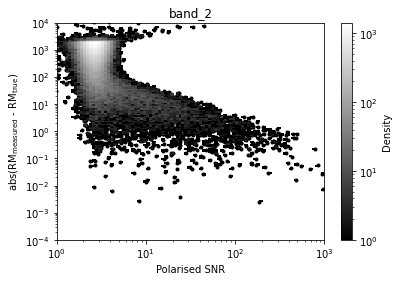

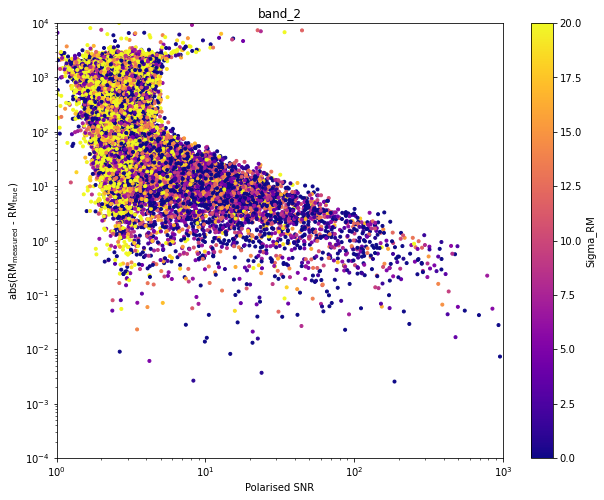

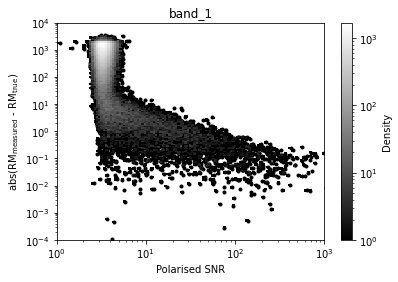

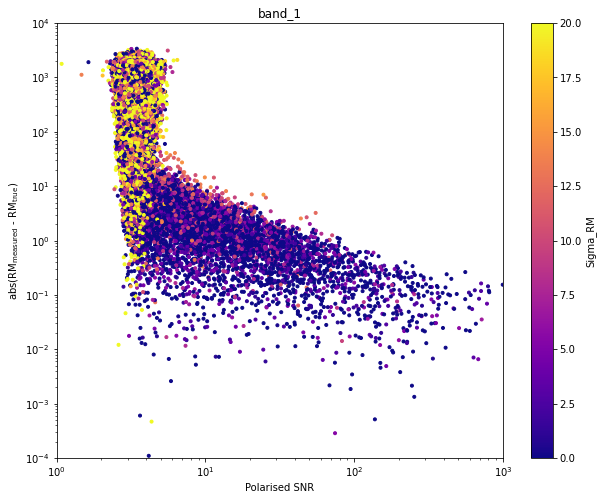

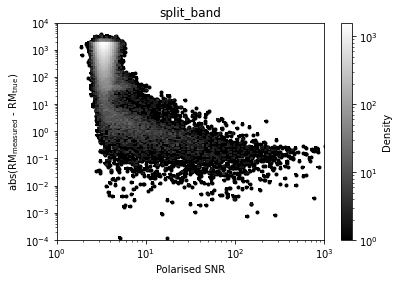

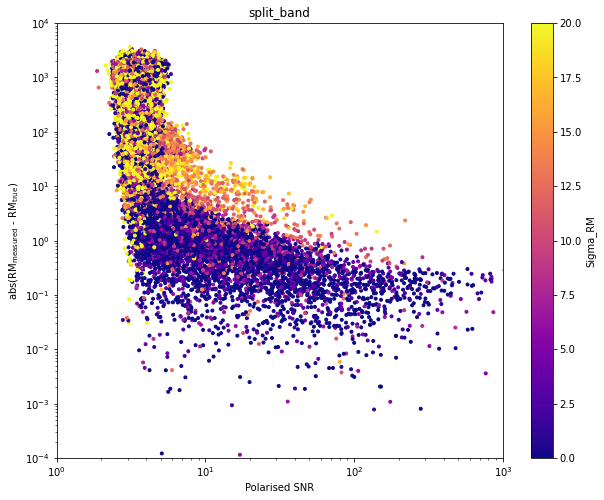

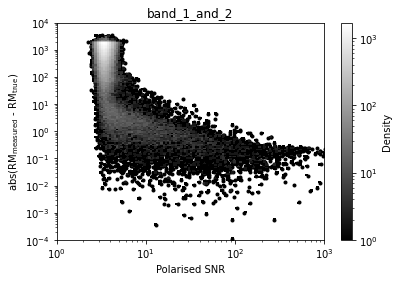

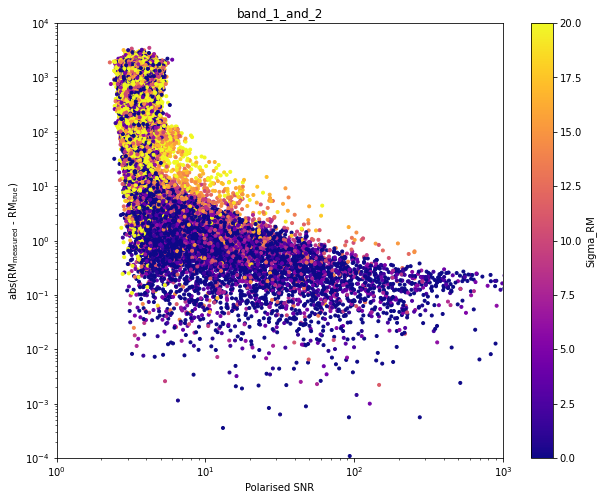

In [119]:
for band in ["band_2", "band_1", "split_band", "band_1_and_2"]:
    print(f"{band=}")
    tab = Table.read(f"{band}_sim_cat.csv")
    rm_meas = tab['phiPeakPIfit_rm2_CLEAN']
    rm_true = tab['Rotation Measure']
    snr_meas = tab['snrPIfit_CLEAN']
    sigmas = tab['Sigma_RM']
    detect = np.array(snr_meas) > 10
    diff = rm_meas - rm_true
    abs_diff = np.abs(diff)
    ybins = np.logspace(np.log10(np.nanmin(abs_diff)), np.log10(np.nanmax(abs_diff)), 150)
    xbins = np.logspace(np.log10(np.nanmin(np.abs(snr_meas))), np.log10(np.nanmax(snr_meas)), 150)
    dens = np.sum(detect) / AREA
    print(f"{dens=}sources/deg^2")
    # delta_RM = np.nanmedian(diff[detect]**2)
    delta_RM = np.nanmedian(abs_diff[detect])
    print(f"{delta_RM=}rad/m^2")
    FOM = ( delta_RM / np.sqrt(dens))**(-1)
    print(f"{FOM=}")
    fig = plt.figure(facecolor='w')
    counts,xedges,yedges,image = plt.hist2d(snr_meas, abs_diff, 
                                    bins=[xbins,ybins],

    #                                       bins=10000,
                norm=plt.cm.colors.LogNorm(),
                            cmap=plt.cm.binary_r
                )
    plt.colorbar(label='Density')
    plt.plot(snr_meas,abs_diff, 'k.', zorder=0)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Polarised SNR')
    plt.ylabel(r'abs(RM$_\mathrm{measured}$ - RM$_\mathrm{true})$')
    plt.title(f'{band}')
    plt.xlim(1e0, 1e3)
    plt.ylim(1e-4, 1e4)
    fig = plt.figure(facecolor='w', figsize=(10,8))
    plt.scatter(snr_meas,abs_diff, marker='.', c=np.array(sigmas),
                cmap=plt.cm.plasma,
                # norm=plt.cm.colors.LogNorm()
    )
    plt.colorbar(label='Sigma_RM')
    plt.clim(0,20)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Polarised SNR')
    plt.ylabel(r'abs(RM$_\mathrm{measured}$ - RM$_\mathrm{true})$')
    plt.title(f'{band}')
    plt.xlim(1e0, 1e3)
    plt.ylim(1e-4, 1e4)

dens=26.64sources/deg^2
delta_RM=1.6712824439711336rad/m^2
FOM=3.088284196871947


(0.0001, 10000.0)

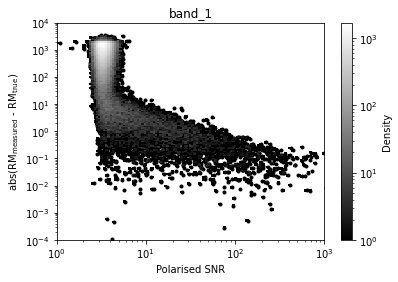

(0.0001, 10000.0)

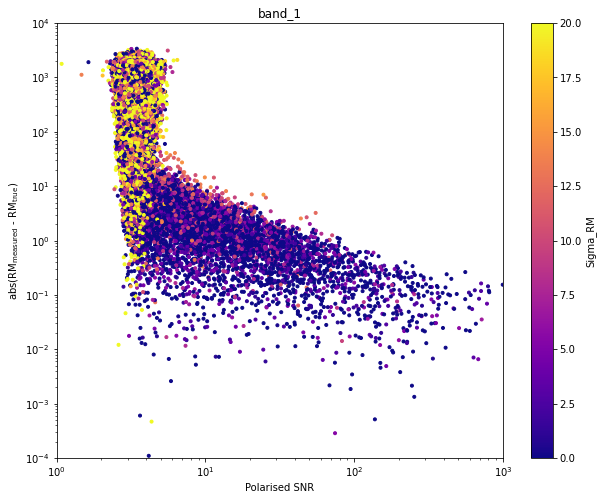

<ipython-input-105-646fcf552a5a>:1: RuntimeWarning: invalid value encountered in true_divide
  test = np.sum(counts * ybins[:-1, np.newaxis], axis=0) / np.nansum(counts, axis=0)


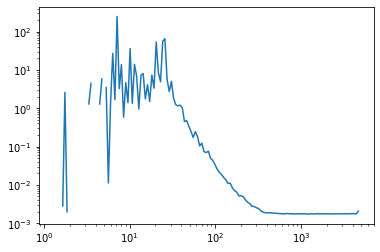

In [105]:
test = np.sum(counts * ybins[:-1, np.newaxis], axis=0) / np.nansum(counts, axis=0)
plt.plot(xbins[:-1],test)
plt.xscale('log')
plt.yscale('log')

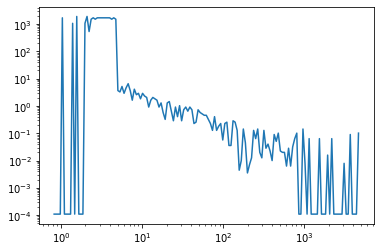

In [98]:
test = ybins[np.argmax(counts,axis=1)]
plt.plot(xbins[:-1],test)
plt.xscale('log')
plt.yscale('log')

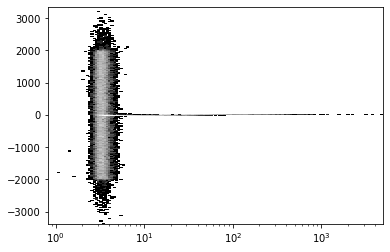

In [87]:
fig = plt.figure(facecolor='w')
counts,xedges,yedges,image = plt.hist2d(snr_meas, diff,
                                        bins=[xbins,1000],
                                # bins=[xbins,ybins],

#                                       bins=10000,
               norm=plt.cm.colors.LogNorm(),
                          cmap=plt.cm.binary_r
              )
# plt.colorbar(label='Density')
# plt.plot(snr_meas,abs_diff, 'k.', zorder=0)
plt.xscale('log')
# plt.yscale('log')
# plt.xlabel('Polarised SNR')
# plt.ylabel(r'abs(RM$_\mathrm{measured}$ - RM$_\mathrm{true})$')
# plt.title(f'{band}')
# plt.xlim(1e0, 1e3)
# plt.ylim(1e-4, 1e4)

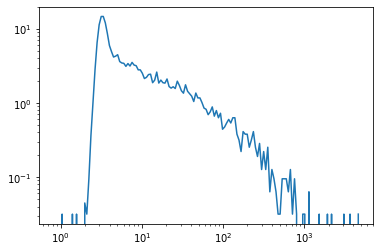

In [90]:
test = np.nanstd(counts,axis=1)
plt.plot(xbins[:-1], test)
plt.xscale('log')
plt.yscale('log')
# plt.xlim(1e1, 1e3)

(0.0001, 10000.0)

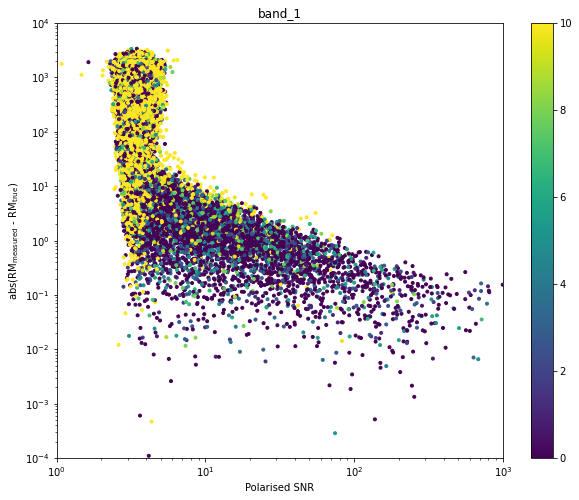

(array([3.3295e+04, 1.8045e+04, 1.7250e+04, 1.2660e+04, 7.3560e+03,
        3.3220e+03, 1.1040e+03, 3.0700e+02, 6.8000e+01, 1.4000e+01]),
 array([ 0.        ,  7.48553165, 14.97106331, 22.45659496, 29.94212662,
        37.42765827, 44.91318993, 52.39872158, 59.88425324, 67.36978489,
        74.85531655]),
 <BarContainer object of 10 artists>)

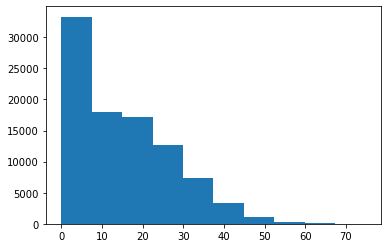

In [53]:
plt.hist(sigmas)